# MNIST autoencoder

In [1]:
%matplotlib widget

import os, math, random
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Reshape, Conv2DTranspose, ReLU
from tensorflow.keras.datasets import mnist
from pathlib import Path

np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow:", tf.__version__)


TensorFlow: 2.20.0


In [2]:
# ─────────────────────────────────────────────────────────
# CONFIG — set this back to your original style/path
# ─────────────────────────────────────────────────────────
RESULTS_DIR       = Path("..") / "data" / "mnist-ae"   # ← change to your actual folder if needed
LATENTS_H5        = os.path.join(RESULTS_DIR, "latents.h5")
DECODER_WEIGHTS   = os.path.join(RESULTS_DIR, "decoder_weights.h5")

# Must match training
N_LAYERS      = 2
BASE_FILTERS  = 16
LATENT_DIM    = 64

# Geometric median settings
GEOMED_MAX_ITERS = 1000
GEOMED_TOL       = 1e-7
GEOMED_SUBSAMPLE = None

print("RESULTS_DIR:", RESULTS_DIR)
assert os.path.exists(LATENTS_H5),      f"Missing file: {LATENTS_H5}"
assert os.path.exists(DECODER_WEIGHTS), f"Missing file: {DECODER_WEIGHTS}"


RESULTS_DIR: ..\data\mnist-ae


In [3]:
with h5py.File(LATENTS_H5, "r") as hf:
    Z      = hf["z"][:].astype(np.float32)     # (N, D)
    labels = hf["labels"][:].astype(np.int64)   # (N,)

N, D = Z.shape
print(f"Loaded Z: {Z.shape}, labels: {labels.shape}")
assert D == LATENT_DIM, f"LATENT_DIM mismatch: expected {LATENT_DIM}, got {D}"


Loaded Z: (70000, 64), labels: (70000,)


In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.expand_dims(x_train.astype("float32") / 255.0, -1)
x_test  = np.expand_dims(x_test.astype("float32")  / 255.0, -1)

ALL_IMAGES = np.concatenate([x_train, x_test], axis=0)
ALL_LABELS = np.concatenate([y_train, y_test], axis=0)
assert ALL_IMAGES.shape[0] == N, "Mismatch between number of latents and images"

print("ALL_IMAGES:", ALL_IMAGES.shape, "ALL_LABELS:", ALL_LABELS.shape)


ALL_IMAGES: (70000, 28, 28, 1) ALL_LABELS: (70000,)


In [5]:
target_label = 4
idx_subset = np.where(labels == target_label)[0]

if idx_subset.size == 0:
    raise ValueError(f"No samples found with label == {target_label}")

Z_sub   = Z[idx_subset]
IM_sub  = ALL_IMAGES[idx_subset]
LBL_sub = labels[idx_subset]

print(f"Subset size for label {target_label}: {Z_sub.shape[0]} latents")


Subset size for label 4: 6824 latents


In [6]:
def build_decoder(n_layers=2, base_filters=16, latent_dim=64):
    latent_in = Input((latent_dim,), name="z_sampling")
    spatial   = 28 // (2**n_layers)  # 28 -> 7 for 2 layers
    channels  = base_filters * (2**(n_layers-1))

    x = Dense(spatial * spatial * channels)(latent_in)
    x = Reshape((spatial, spatial, channels))(x)

    for i in reversed(range(n_layers)):
        f = base_filters * (2**i)
        x = Conv2DTranspose(f, 3, strides=(2,2), padding="same")(x)
        x = ReLU()(x)

    out = tf.keras.layers.Conv2D(1, 3, padding="same", activation="sigmoid", name="decoder_output")(x)
    return Model(latent_in, out, name="decoder")

decoder = build_decoder(N_LAYERS, BASE_FILTERS, LATENT_DIM)
decoder.load_weights(DECODER_WEIGHTS)
print("Decoder loaded from:", DECODER_WEIGHTS)

_ = decoder.predict(np.zeros((1, LATENT_DIM), dtype=np.float32), verbose=0)


Decoder loaded from: ..\data\mnist-ae\decoder_weights.h5


In [7]:
def geometric_median(points, tol=1e-7, max_iters=1000):
    P = points.astype(np.float64)
    x = P.mean(axis=0)
    eps = 1e-12
    for _ in range(max_iters):
        diff = P - x
        d    = np.linalg.norm(diff, axis=1) + eps
        w    = 1.0 / d
        x_new = (w[:, None] * P).sum(axis=0) / w.sum()
        if np.linalg.norm(x_new - x) <= tol:
            return x_new.astype(np.float32)
        x = x_new
    return x.astype(np.float32)

mean_z   = Z_sub.mean(axis=0)
median_z = np.median(Z_sub, axis=0)

if GEOMED_SUBSAMPLE is None or GEOMED_SUBSAMPLE >= Z_sub.shape[0]:
    gm_input = Z_sub
else:
    sel = np.random.choice(Z_sub.shape[0], GEOMED_SUBSAMPLE, replace=False)
    gm_input = Z_sub[sel]

geom_z = geometric_median(gm_input, tol=GEOMED_TOL, max_iters=GEOMED_MAX_ITERS)
print("Central latents computed for label==4 subset.")


Central latents computed for label==4 subset.


In [8]:
central_stack = np.stack([mean_z, median_z, geom_z], axis=0).astype(np.float32)
recons = decoder.predict(central_stack, verbose=0)  # (3, 28, 28, 1)
recons = np.squeeze(recons, axis=-1)                # -> (3, 28, 28)
print("Reconstructions:", recons.shape)


Reconstructions: (3, 28, 28)


In [9]:
def nearest_idx(vec, Z):
    diff = Z - vec[None, :]
    d2   = np.sum(diff*diff, axis=1)
    idx  = int(np.argmin(d2))
    dist = float(np.sqrt(d2[idx]))
    return idx, dist

mean_i_sub,   mean_dist   = nearest_idx(mean_z,   Z_sub)
median_i_sub, median_dist = nearest_idx(median_z, Z_sub)
geom_i_sub,   geom_dist   = nearest_idx(geom_z,   Z_sub)

mean_idx_global   = int(idx_subset[mean_i_sub])
median_idx_global = int(idx_subset[median_i_sub])
geom_idx_global   = int(idx_subset[geom_i_sub])

closest_global_indices = [mean_idx_global, median_idx_global, geom_idx_global]
closest_dists          = [mean_dist, median_dist, geom_dist]
closest_labels         = [int(labels[i]) for i in closest_global_indices]  # should all be 4
closest_images         = [ALL_IMAGES[i, ..., 0] for i in closest_global_indices]

print("Closest (global) indices:", closest_global_indices)
print("Distances:", [f"{d:.6f}" for d in closest_dists])
print("Labels   :", closest_labels)


Closest (global) indices: [3639, 3639, 3639]
Distances: ['2.435483', '2.347138', '2.327151']
Labels   : [4, 4, 4]


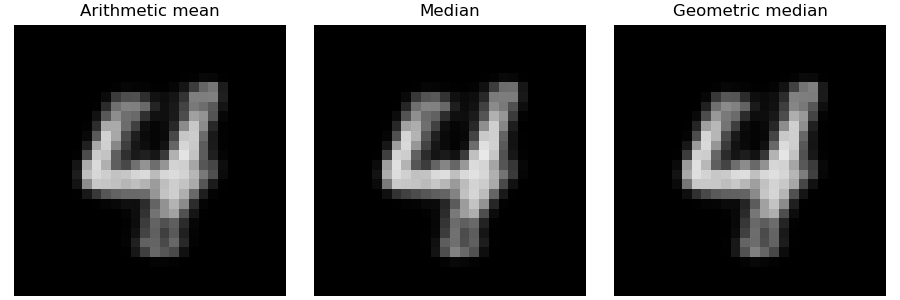

In [10]:
#| label: fig2c_data

titles = ["Arithmetic mean", "Median", "Geometric median"]
fig1, axes1 = plt.subplots(1, 3, figsize=(9, 3), constrained_layout=True)
for ax, img, title in zip(axes1, recons, titles):
    ax.imshow(img, cmap="gray", vmin=0, vmax=1)
    ax.set_title(title)
    ax.axis("off")
fig1.canvas.header_visible = False
plt.show()


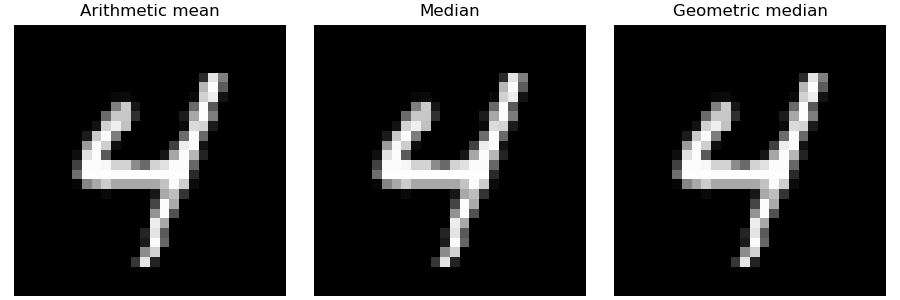

In [11]:
#| label: fig2d_data

titles2 = ["Arithmetic mean", "Median", "Geometric median"]
fig2, axes2 = plt.subplots(1, 3, figsize=(9, 3), constrained_layout=True)
for ax, img, title in zip(axes2, closest_images, titles2):
    ax.imshow(img, cmap="gray", vmin=0, vmax=1)
    ax.set_title(title)
    ax.axis("off")
fig2.canvas.header_visible = False
plt.show()


In [12]:
summary = {
    "subset_size_label4": int(Z_sub.shape[0]),
    "mean":   {"global_index": int(closest_global_indices[0]), "distance": float(closest_dists[0]), "label": int(closest_labels[0])},
    "median": {"global_index": int(closest_global_indices[1]), "distance": float(closest_dists[1]), "label": int(closest_labels[1])},
    "geom":   {"global_index": int(closest_global_indices[2]), "distance": float(closest_dists[2]), "label": int(closest_labels[2])},
}
summary


{'subset_size_label4': 6824,
 'mean': {'global_index': 3639, 'distance': 2.4354825019836426, 'label': 4},
 'median': {'global_index': 3639, 'distance': 2.3471381664276123, 'label': 4},
 'geom': {'global_index': 3639, 'distance': 2.32715106010437, 'label': 4}}